style classifier - some code inspired by https://github.com/nicku-a/Weather_Classification/blob/main/WeatherClassifier.ipynb

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from diffusers import DiffusionPipeline
import numpy as np
import random
import torch
from diffusers import StableDiffusionPipeline
import glob
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Union
import pandas as pd

from fid.fid_score import calculate_activation_statistics, save_statistics, load_statistics, calculate_frechet_distance, get_activations
from fid.inception import InceptionV3

from PIL import Image
from tqdm.auto import tqdm
from torch import autocast

from src.visualise import image_grid, latent_to_img, decode_latent, output_to_img
from schedulers.euler_discrete import EulerDiscreteCustomScheduler, FrozenDict, randn_tensor
from src.score_utils import get_sigmas, get_score_input, scale_input, get_score, step_score, denoise
from src.sampling_utils import random_step, langevin_step, repulsive_step_parallel
from src.kernel import RBF
from src.embedding import CNN64, CNN16, init_weights, AverageDim, Average, VAEAverage, Style

import torch
import torch.nn as nn
import torch.nn.functional as F
# import autograd.numpy as anp
from collections import deque

# Using 512x512 resolution
model_id = "stabilityai/stable-diffusion-2-base"
# model_id = "CompVis/stable-diffusion-v1-4"

# tf32 faster computation with Ampere
torch.backends.cuda.matmul.allow_tf32 = True
device = "cuda"
dtype=torch.float32
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=dtype)
# pipe = pipe.to(device)
pipe.safety_checker = None
pipe.enable_attention_slicing() # NOTE: 10% slower inference, but big memory savings
# pipe.enable_sequential_cpu_offload() # NOTE: May slow down inference a lot
pipe.enable_vae_slicing() # TODO: Try to give batches to VAE
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

# Traced UNet? https://huggingface.co/docs/diffusers/optimization/fp16

/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Settings
prompt =  ["tree, abstract expressionism, realism"]
config = {
    "pipe": pipe,
    "height": 512,
    "width": 512,
    "num_inference_steps": 20,
    "num_train_timesteps": 1000,
    "num_init_latents": 1,
    "batch_size": 1,
    "cfg": 8,
    "beta_start": 0.00085,
    "beta_end": 0.012,
}

# Seeds
seed=1024
generator = torch.Generator(device).manual_seed(seed)
torch.manual_seed(seed)
np.random.seed(0)
random.seed(0)

# Noise levels
sigmas, timesteps = get_sigmas(config, device=device)
init_latents, text_embeddings = get_score_input(prompt, config, generator=generator, device=device, dtype=dtype)
config = {**config,
          "sigmas": sigmas,
          "timesteps": timesteps,
          "init_latents": init_latents,
          "text_embeddings": text_embeddings
          }

/data/ap2619/particlediffusion/src/score_utils.py:60: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, pipe.unet.in_channels, height//8, width//8),


In [25]:
latent = denoise([], 0, config, return_all_samples=True, generator=generator)

100%|██████████| 20/20 [00:03<00:00,  5.59it/s]


In [26]:
latent = torch.cat(latent)

In [ ]:
# Plot image results
images = decode_latent(latent, pipe.vae)
images = output_to_img(images)
images = (images * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]

max_cols = 10
numparticles = len(pil_images)
ncols = max_cols if numparticles > max_cols else numparticles
nrows = int(np.ceil(numparticles / ncols))
grid = image_grid(pil_images,nrows,ncols)
grid

In [ ]:
seed=0
generator = torch.Generator(device).manual_seed(seed)
torch.manual_seed(seed)
# For each style, create 500 images of "tree, {style}"
# Store all 21 latents as a torch
styles =  pd.read_csv("data/styles/styles.csv",header=None)
for style in styles[0]:
    # prompt = f"{label} on a white plate"
    prompt = f"tree, {style}"
    filename = "tree_" + style.replace(" ", "_")
    dst_path = os.path.join("data","styles", "latents", filename)
    os.makedirs(dst_path, exist_ok=True)
    print(style)
    for i in range(1):
        print(f"{filename}_{i}.png")
        latents = denoise([], 0, config, return_all_samples=True, generator=generator)
        latents = torch.cat(latents)
        torch.save(latents, os.path.join(dst_path , f"{filename}_{i}.pt"))

In [ ]:
latents = torch.load('data/styles/realism/tree_realism_1.pt')
images = decode_latent(latents, pipe.vae)
images = output_to_img(latents)
images = (images * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]

max_cols = 10
numparticles = len(pil_images)
ncols = max_cols if numparticles > max_cols else numparticles
nrows = int(np.ceil(numparticles / ncols))
grid = image_grid(pil_images,nrows,ncols)
grid

In [34]:
[style.replace(" ", "_") for style in styles[0]]

['realism', 'cubism', 'impressionism', 'abstract_expressionism', 'photo']

In [120]:
from torch.utils.data import DataLoader, Dataset, random_split
from glob import glob

class StyleDataset(Dataset):
    def __init__(self, device="cuda"):
        self.img_dir = 'data/styles'
        self.noise_levels = 21
        self.device = device

        styles = pd.read_csv(f"{self.img_dir}/styles.csv",header=None)
        self.styles = [style.replace(" ", "_") for style in styles[0]]
        self.styles_num = []
        for style in self.styles:
            self.styles_num.append(len(glob(f'{self.img_dir}/{style}/*')))
        
        # Label format: (style, #data, noise_levels)
        # self.labels = [(label, n, noise_lvl) for label in range(len(self.styles)) for n in range(self.styles_num[label]) for noise_lvl in range(21)]
        self.labels = [(label, n) for label in range(len(self.styles)) for n in range(self.styles_num[label])]
        
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # Returns Nx4x64x64 latent, 
        # Choose style_i, #data, noise_levels
        # label, n, noise_lvl = self.labels[idx]
        label, n = self.labels[idx]
        style = self.styles[label]
        img_path = os.path.join(self.img_dir, style, f"tree_{style}_{n}.pt")
        latents = torch.load(img_path)
        x = latents.to(self.device)
        y = torch.tensor(label).to(self.device)
        return x,y


In [121]:
# Dataset
dataset = StyleDataset()
train_sz = int(0.7 * len(dataset))
val_sz = int(0.1 * len(dataset))
test_sz = len(dataset) - train_sz - val_sz
train_set, val_set, test_set = random_split(dataset, [train_sz,val_sz,test_sz])

# Dataloader
batch_size = 32
train_dl = DataLoader(train_set, batch_size=32, shuffle=True)
val_dl = DataLoader(val_set, batch_size=val_sz)
test_dl = DataLoader(test_set, batch_size=test_sz)

In [221]:
class VGG(nn.Module):
    def __init__(self, num_outputs=5, logsoftmax=True):
        super().__init__()

        self.num_outputs = num_outputs
        self.logsoftmax = logsoftmax

        self.conv_layers = []
        self.num_blocks = 4
        for i in range(self.num_blocks):
            layer = nn.Conv2d(4*2**i,4*2**(i+1),kernel_size=(3,3), stride=1, padding=1)
            self.conv_layers.append(layer)
        final_nchannels = 4*2**self.num_blocks
        conv_final = nn.Conv2d(final_nchannels, final_nchannels, kernel_size=(4,4))
        self.conv_layers.append(conv_final)

        self.conv_layers = nn.ModuleList(self.conv_layers)

        self.act = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        self.fc = nn.Linear(in_features=final_nchannels, out_features=num_outputs, bias=True)

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Conv layers
        for i, conv_layer in enumerate(self.conv_layers):
            x = conv_layer(x)
            if i != len(self.conv_layers)-1:
                x = self.maxpool(self.act(x))
        
        # FC layer
        x = x.squeeze(-2,-1)
        x = self.fc(x)
        if self.logsoftmax:
            x = self.logsoftmax(x)
        
        return x


In [208]:
# Train model
def train(model, criterion, epochs, opt, train_dl, val_dl):
   
    # Lists to track training progress
    train_losses = []
    validation_losses = []
    train_accs = []
    validation_accs = []
    
    print('Training progress:')
    for epoch in tqdm(range(epochs)):   # Show progress bar with tqdm
        
        if epoch % 10 ==0:
            print('Epoch {}/{}'.format(epoch+1, epochs))
        model.train()
        total_correct = 0
        train_loss = 0
        samples = 0

        # Iterate through batches, train model
        for x_train, y_train in train_dl:
            # choose random noise level
            noise_level = random.randrange(0,dataset.noise_levels)
            pred = model(x_train[:,noise_level,...])
            loss = criterion(pred, y_train)

            loss.backward()
            opt.step()
            opt.zero_grad()

            # Calculate batch accuracy
            confidence, predicted = torch.max(pred.data, 1)
            correct = (predicted == y_train).sum().item()
            
            train_loss += loss.item()
            total_correct += correct
            samples += y_train.size(0)

        train_acc = total_correct/samples
        train_loss = train_loss/len(train_dl)

        # Use validation data to check for overfitting
        model.eval()
        with torch.no_grad():
            val_loss = 0
            total_correct = 0
            samples = 0
            for x_val, y_val in val_dl:
                # evaluate at all noise levels
                for noise_level in range(dataset.noise_levels):
                    pred = model(x_val[:,noise_level,...])
                    loss = criterion(pred, y_val)

                    confidence, predicted = torch.max(pred.data, 1)
                    correct = (predicted == y_val).sum().item()

                    val_loss += loss.item()
                    total_correct += correct
                    samples += y_val.size(0)

        val_acc = total_correct / samples
        val_loss = val_loss / (len(val_dl)*dataset.noise_levels)
        
        train_losses.append(train_loss)
        validation_losses.append(val_loss)
        train_accs.append(train_acc)
        validation_accs.append(val_acc)
        
        if epoch % 10 ==0:
            print('loss = {}      accuracy = {}      val_loss = {}      val_accuracy: {}'.format(train_loss, train_acc, val_loss, val_acc))

    print('Final training loss =   {}      final training accuracy =   {}'.format(train_loss, train_acc))
    print('Final validation loss = {}      final validation accuracy = {}'.format(val_loss, val_acc))

    # Save state dict for future loading of trained model
    torch.save(model.state_dict(), f'data/model_chk/classifier_epoch{epoch+1}.pt')
    torch.save(opt.state_dict(), f'data/model_chk/classifier_opt_epoch{epoch+1}.pt')
    print('Saved state dict')

    return train_losses, validation_losses, train_accs, validation_accs

In [211]:
from torch import optim

model = VGG()
device="cuda"
model.to(device)

criterion = nn.NLLLoss()
lr = 1e-3
epochs = 100
opt = optim.Adam(model.parameters(), lr=lr)
batches = len(train_dl)

seed=0
generator = torch.Generator(device).manual_seed(seed)
torch.manual_seed(seed)
train_losses, val_losses, train_accs, val_accs = train(model, criterion, epochs, opt, train_dl, val_dl)

Training progress:


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100


  1%|          | 1/100 [00:00<00:44,  2.22it/s]

loss = 1.6483505097302524      accuracy = 0.21428571428571427      val_loss = 1.6441892953146071      val_accuracy: 0.16380952380952382


 10%|█         | 10/100 [00:04<00:40,  2.20it/s]

Epoch 11/100


 11%|█         | 11/100 [00:05<00:40,  2.20it/s]

loss = 1.3317863074215976      accuracy = 0.49142857142857144      val_loss = 1.325695003782      val_accuracy: 0.47714285714285715


 20%|██        | 20/100 [00:09<00:36,  2.20it/s]

Epoch 21/100


 21%|██        | 21/100 [00:09<00:35,  2.20it/s]

loss = 1.1944204297932712      accuracy = 0.5171428571428571      val_loss = 1.0833966022446042      val_accuracy: 0.5028571428571429


 30%|███       | 30/100 [00:13<00:31,  2.20it/s]

Epoch 31/100


 31%|███       | 31/100 [00:14<00:31,  2.20it/s]

loss = 0.8301208236000754      accuracy = 0.6971428571428572      val_loss = 1.230397003037589      val_accuracy: 0.52


 40%|████      | 40/100 [00:18<00:27,  2.20it/s]

Epoch 41/100


 41%|████      | 41/100 [00:18<00:26,  2.20it/s]

loss = 0.6694579571485519      accuracy = 0.7714285714285715      val_loss = 1.2438354179972695      val_accuracy: 0.5495238095238095


 50%|█████     | 50/100 [00:22<00:22,  2.20it/s]

Epoch 51/100


 51%|█████     | 51/100 [00:23<00:22,  2.20it/s]

loss = 0.28686231103810395      accuracy = 0.9285714285714286      val_loss = 1.5063455048061551      val_accuracy: 0.5428571428571428


 60%|██████    | 60/100 [00:27<00:18,  2.20it/s]

Epoch 61/100


 61%|██████    | 61/100 [00:27<00:17,  2.19it/s]

loss = 0.19808771461248398      accuracy = 0.9485714285714286      val_loss = 1.9272752773194086      val_accuracy: 0.5276190476190477


 70%|███████   | 70/100 [00:31<00:13,  2.20it/s]

Epoch 71/100


 71%|███████   | 71/100 [00:32<00:13,  2.21it/s]

loss = 0.5561346730048006      accuracy = 0.8      val_loss = 1.4605919605209714      val_accuracy: 0.5238095238095238


 80%|████████  | 80/100 [00:36<00:09,  2.22it/s]

Epoch 81/100


 81%|████████  | 81/100 [00:36<00:08,  2.21it/s]

loss = 0.03095201834697615      accuracy = 0.9971428571428571      val_loss = 2.057554494766962      val_accuracy: 0.5419047619047619


 90%|█████████ | 90/100 [00:40<00:04,  2.22it/s]

Epoch 91/100


 91%|█████████ | 91/100 [00:41<00:04,  2.22it/s]

loss = 0.02492668352682482      accuracy = 1.0      val_loss = 2.358283042907715      val_accuracy: 0.5447619047619048


100%|██████████| 100/100 [00:45<00:00,  2.20it/s]

Final training loss =   0.011365776818076318      final training accuracy =   1.0
Final validation loss = 2.6690711918331327      final validation accuracy = 0.54
Saved state dict


In [229]:
model1 = VGG(logsoftmax=False)
model1.load_state_dict(torch.load('data/model_chk/classifier_epoch100.pt'))

<All keys matched successfully>

In [231]:
torch.exp(model1(train_set[0][0].cpu()))

tensor([[6.6702e-12, 9.6376e-04, 9.9903e-01, 1.5959e-16, 1.8469e-06],
        [1.7520e-10, 5.0191e-06, 9.9999e-01, 1.1515e-15, 5.0497e-06],
        [3.2967e-10, 4.2396e-07, 9.9999e-01, 6.4821e-14, 5.8955e-06],
        [4.4829e-10, 2.1803e-07, 9.9998e-01, 2.6052e-12, 1.8245e-05],
        [6.9240e-10, 2.7130e-08, 9.9999e-01, 1.4095e-12, 1.0648e-05],
        [1.4173e-09, 4.4372e-09, 1.0000e+00, 6.3527e-13, 4.7573e-06],
        [2.7020e-09, 1.4916e-09, 1.0000e+00, 3.0535e-13, 3.2161e-06],
        [2.9353e-09, 1.0287e-09, 1.0000e+00, 2.4524e-13, 3.3894e-06],
        [2.4572e-09, 9.7773e-10, 1.0000e+00, 3.1128e-13, 4.5493e-06],
        [3.0652e-09, 1.2258e-09, 9.9999e-01, 7.0252e-13, 1.2595e-05],
        [4.8803e-09, 1.5000e-09, 9.9997e-01, 1.6190e-12, 2.7107e-05],
        [8.3250e-09, 1.8145e-09, 9.9996e-01, 3.1469e-12, 4.1746e-05],
        [1.4720e-08, 2.5495e-09, 9.9992e-01, 7.8487e-12, 7.8417e-05],
        [2.9983e-08, 3.8446e-09, 9.9986e-01, 1.8971e-11, 1.3592e-04],
        [5.7230e-08,

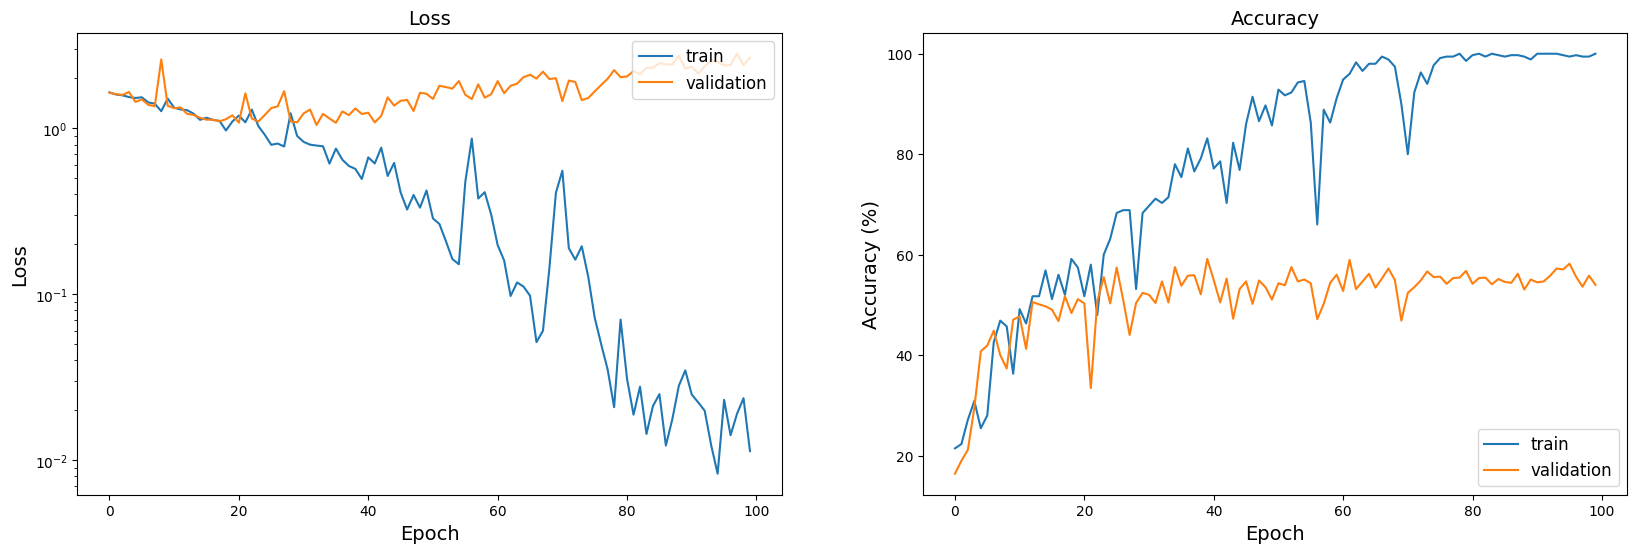

In [212]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
# fig.suptitle('Training Curves', fontsize=20)

ax1.plot(train_losses)
ax1.plot(val_losses)
ax1.set_title('Loss', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_yscale('log')
ax1.legend(['train', 'validation'], loc = 'upper right', fontsize=12)

ax2.plot(np.multiply(train_accs,100))
ax2.plot(np.multiply(val_accs,100))
ax2.set_title('Accuracy', fontsize=14)
ax2.set_ylabel('Accuracy (%)', fontsize=14)
ax2.set_xlabel('Epoch', fontsize=14)
# plt.yscale('log')
ax2.legend(['train', 'validation'], loc = 'lower right', fontsize=12)

plt.show()

In [188]:
from sklearn.metrics import classification_report, precision_score, recall_score
# Test model on testing dataset
classes = dataset.styles
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
correct = 0
total = 0
confusion_matrix = np.zeros((len(classes), len(classes)))

confidence = [] # confidence for each noise level
with torch.no_grad():
    for lvl in range(dataset.noise_levels):
        for i, (images, labels) in enumerate(test_dl):
            predictions = model(images[:,lvl,...])
            conf, predicted = torch.max(predictions.data, 1)
            confidence.append(torch.exp(conf))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
            # Analyse errors for per-class accuracy and confusion matrix
            for true_label, pred_label in zip(labels, predicted):
                if true_label == pred_label:
                    correct_pred[classes[true_label]] += 1
                total_pred[classes[true_label]] += 1
                confusion_matrix[true_label, pred_label] += 1

confidence = torch.stack(confidence)
# Calculate per-class accuracy
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))

print('----------------------------------------')
print('Network Accuracy: {:.2f} %'.format(100 * correct / total))
print('----------------------------------------')
print(classification_report(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy()))

Accuracy for class realism is: 54.9 %
Accuracy for class cubism is: 60.4 %
Accuracy for class impressionism is: 64.0 %
Accuracy for class abstract_expressionism is: 33.8 %
Accuracy for class photo is: 45.4 %
----------------------------------------
Network Accuracy: 50.90 %
----------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        19
           1       0.57      0.81      0.67        16
           2       0.62      0.75      0.68        20
           3       0.79      0.52      0.63        21
           4       0.85      0.71      0.77        24

    accuracy                           0.69       100
   macro avg       0.70      0.70      0.69       100
weighted avg       0.71      0.69      0.69       100



/tmp/ipykernel_536271/493434604.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(bar_labels, fontsize='15')


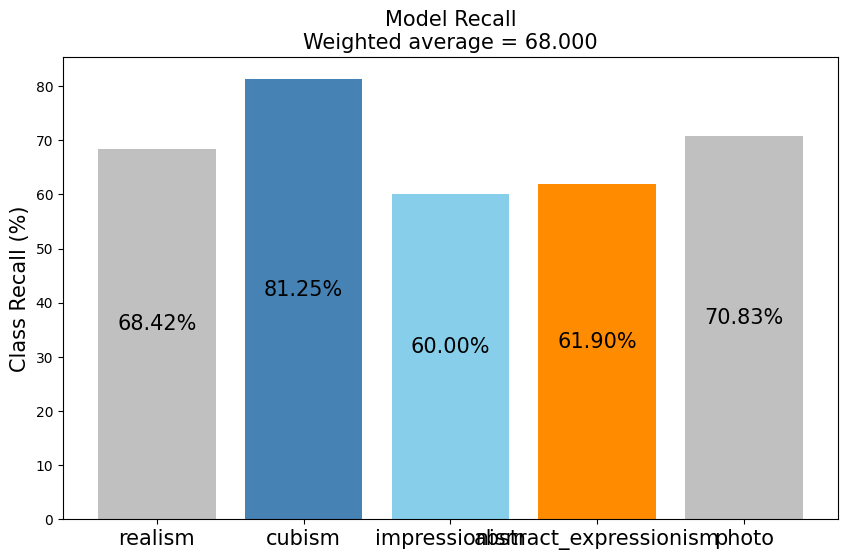

/tmp/ipykernel_536271/493434604.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(bar_labels, fontsize='15')


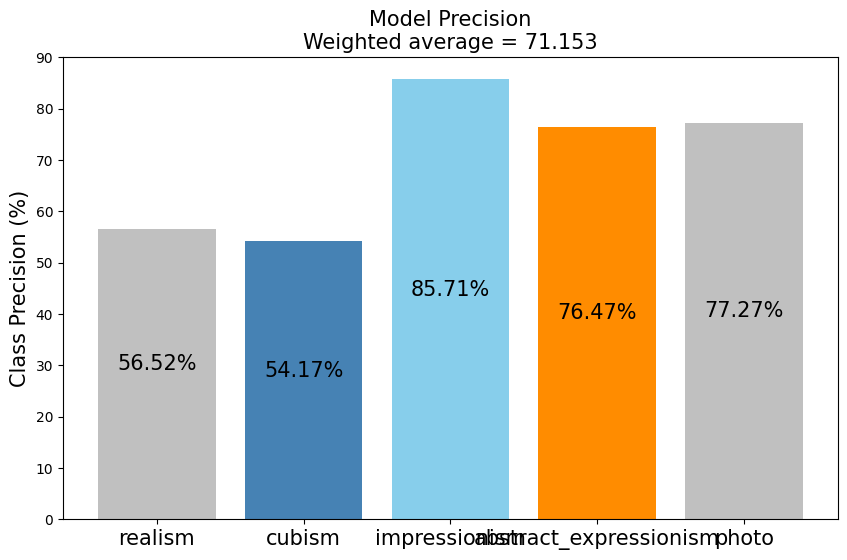

In [145]:

# Plot recall as bar chart
bar_labels = classes
recalls = np.multiply(recall_score(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), average=None), 100)
width = 0.8
fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(bar_labels, recalls, width, color=['silver', 'steelblue', 'skyblue', 'darkorange'])
for i in range(len(bars)):
    ax.annotate('{:.2f}%'.format(recalls[i]), xy=(bar_labels[i],recalls[i]/2), ha='center', va='bottom', fontsize='15')
ax.set_ylabel('Class Recall (%)', fontsize='15')
ax.set_title('Model Recall\nWeighted average = {:.3f}'.format(np.multiply(recall_score(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), average='weighted'), 100)), fontsize='15')
ax.set_xticklabels(bar_labels, fontsize='15')
plt.show()

# Plot precision as bar chart
precs = np.multiply(precision_score(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), average=None), 100)
width = 0.8
fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(bar_labels, precs, width, color=['silver', 'steelblue', 'skyblue', 'darkorange'])
for i in range(len(bars)):
    ax.annotate('{:.2f}%'.format(precs[i]), xy=(bar_labels[i],precs[i]/2), ha='center', va='bottom', fontsize='15')
ax.set_ylabel('Class Precision (%)', fontsize='15')
ax.set_title('Model Precision\nWeighted average = {:.3f}'.format(np.multiply(precision_score(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), average='weighted'), 100)), fontsize='15')
ax.set_xticklabels(bar_labels, fontsize='15')
plt.show()

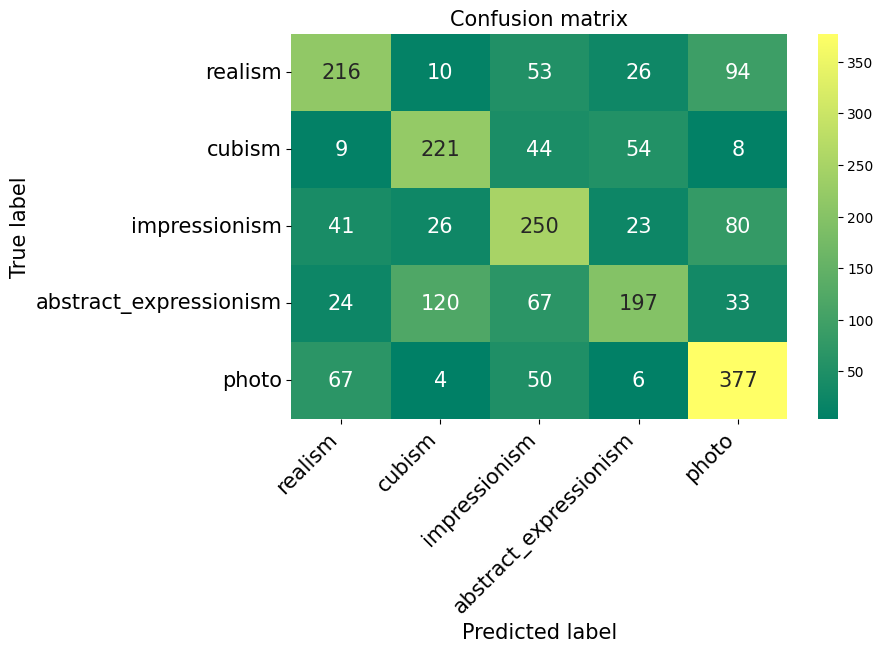

In [146]:
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(8,5))

class_names = list(classes)
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, cmap='summer', annot=True, annot_kws={"size":15}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.title('Confusion matrix', fontsize=15)
plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.show()

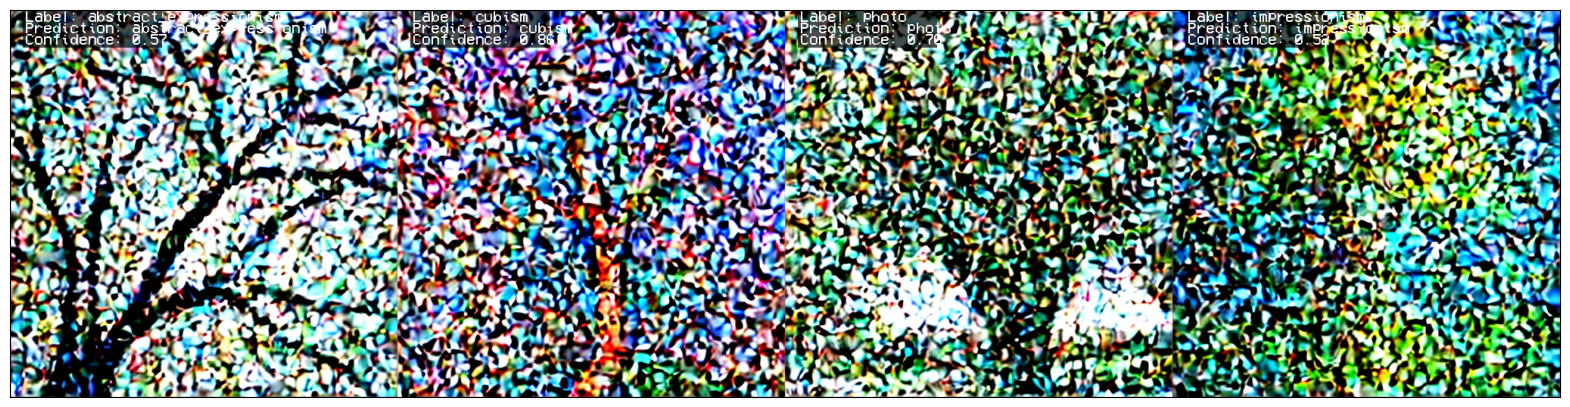

In [189]:
from torchvision.transforms.functional import to_pil_image
import torchvision
from PIL import Image, ImageDraw, ImageFont
# Display example test images with labels, predictions and confidence
# grid_img = to_pil_image(torchvision.utils.make_grid(images[:n], nrow=numrows))
noise_lvl = 10
imgs = decode_latent(images[:4,noise_lvl,...], pipe.vae)
imgs = output_to_img(imgs)
imgs = (imgs * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in imgs]

max_cols = 4
numparticles = len(pil_images)
ncols = max_cols if numparticles > max_cols else numparticles
nrows = int(np.ceil(numparticles / ncols))
grid_img = image_grid(pil_images,nrows,ncols)
width, height = grid_img.size
draw = ImageDraw.Draw(grid_img, 'RGBA')

# Size of rectangles behind text
x_border = 180
y_border = 50
font = ImageFont.truetype('data/pixel.ttf', 20)

i = 0
for row in range(1,nrows+1):
  for col in range(1,ncols+1):
  
    x = width*col/ncols - width/ncols * 0.96
    y = height*row/nrows - height/nrows

    # Rectangle behind text for readabilty
    draw.rectangle((x-3, y-1, x + x_border, y + y_border), fill=(0,0,0,180))

    # Display labels, predictions, confidence
    pred_msg = 'Prediction: {}'.format(classes[predicted[i]])
    conf_msg = 'Confidence: {:.2f}'.format(confidence[noise_lvl,i])
    lab_msg = 'Label: {}'.format(classes[labels[i]])
    draw.text((x,y), lab_msg, fill='white', font=font)
    draw.text((x,y+15), pred_msg, fill='white', font=font)
    draw.text((x,y+30), conf_msg, fill='white', font=font)

    i+=1

plt.figure(figsize=(20,20))
plt.imshow(grid_img)
plt.xticks([])
plt.yticks([])
plt.show()

Text(0, 0.5, 'Confidence')

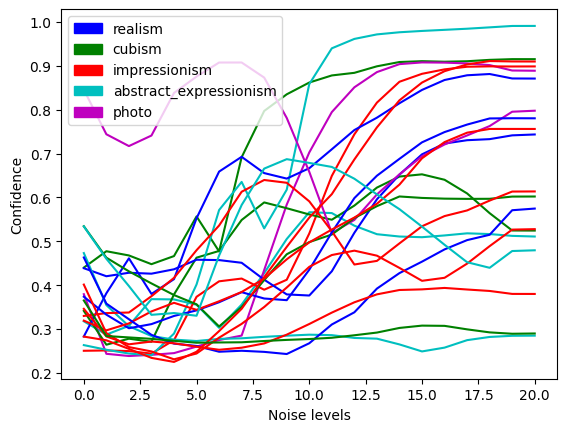

In [206]:
# Plot confidence of predictions at different noise levels
import matplotlib.patches as mpatches
s = dataset.styles
c = {s[0]: 'b', s[1]: 'g', s[2]: 'r', s[3]: 'c', s[4]: 'm'}
for i in range(20):
    plt.plot(confidence[:,i].cpu().numpy(), color=c[classes[labels[i]]])
handles = []
for style, colour in c.items():
    handles.append(mpatches.Patch(color=colour, label=style))
plt.legend(handles=handles)
plt.xlabel("Noise levels")
plt.ylabel("Confidence")